--- 

# <center> Project ML for Time Series 
## <center> Feature Selection: A Data Perspective

<center>Work done by : 

##### <center> Ali HAIDAR email : ali.haidar@polytechnique.edu
##### <center> Maya AWADA  email : maya.awada24@gmail.com 

---

This notebook is divided to several parts:

1- Prepare the data and clean it.

2- Try the feature selection models on the data and Compare them to the feature selected by brute force.

3- Do data augmentation by creating new features.

4 - Try the feature selection models on the augmented data. 

# Preparing the data


We used the data provided by QRT for a challenge on ENS data challenge platform. The aim is to model the electricity price from weather, energy (commodities) and commercial data for two European countries - France and Germany. 

The link of the challenge : https://challengedata.ens.fr/challenges/97

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import Lasso
from sklearn import metrics
from sklearn.linear_model import LassoCV
from sklearn.model_selection import GridSearchCV
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from operator import itemgetter
from itertools import chain, combinations
from tqdm import tqdm
import collections
from sklearn.preprocessing import PolynomialFeatures

import utils
import model
import features_selection

sns.set()
warnings.filterwarnings("ignore")

In [2]:
path = 'data/'
X_train = pd.read_csv( path + 'X_train.csv')
Y_train = pd.read_csv(path + 'Y_train.csv')
X_test = pd.read_csv(path + 'X_test.csv')

## Description of the data

- ID: Unique row identifier, associated with a day (DAY_ID) and a country (COUNTRY),
- DAY_ID: Day identifier - dates have been anonymized, but all data corresponding to a specific day is consistent,
- COUNTRY: Country identifier - DE = Germany, FR = France, 

and then contains daily commodity price variations:

- GAS_RET: European gas,
- COAL_RET: European coal,
- CARBON_RET: Carbon emissions futures,

weather measures (daily, in the country x):

- x_TEMP: Temperature,
- x_RAIN: Rainfall,
- x_WIND: Wind,

energy production measures (daily, in the country x),

- x_GAS: Natural gas,
- x_COAL: Hard coal,
- x_HYDRO: Hydro reservoir,
- x_NUCLEAR: Daily nuclear production,
- x_SOLAR: Photovoltaic,
- x_WINDPOW: Wind power,
- x_LIGNITE: Lignite,

and electricity use metrics (daily, in the country x),

- x_CONSUMPTON: Total electricity consumption,
- x_RESIDUAL_LOAD: Electricity consumption after using all renewable energies,
- x_NET_IMPORT: Imported electricity from Europe,
- x_NET_EXPORT: Exported electricity to Europe,
- DE_FR_EXCHANGE: Total daily electricity exchange between Germany and France,
- FR_DE_EXCHANGE: Total daily electricity exchange between France and Germany.

Output data sets are composed of two columns:

- ID: Unique row identifier - corresponding to the input identifiers,
- TARGET: Daily price variation for futures of 24H electricity baseload.

In [3]:
all_data = pd.merge(X_train, Y_train, on=['ID'])
all_data['train'] = 1
all_data = pd.concat([all_data,X_test])
all_data['TARGET'] = all_data['TARGET'].fillna(0)
all_data['train'] = all_data['train'].fillna(0)
all_data['train']  = all_data['train'].astype(int) 
all_data.describe()

,ID,DAY_ID,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,FR_NET_IMPORT,...,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET,TARGET,train
count,2148.00000,2148.000000,2148.000000,2148.000000,2114.000000,2114.000000,1977.000000,2054.000000,1977.000000,2054.000000,...,2014.000000,2014.000000,2014.000000,2014.000000,2014.000000,2148.000000,2148.000000,2148.000000,2148.000000,2148.000000
mean,1073.50000,604.309125,0.429817,-0.003449,-0.114830,0.114830,-0.245501,-0.088621,0.245501,0.088621,...,0.008455,0.103704,0.109674,-0.005285,-0.009413,0.060070,0.072950,0.070170,0.062552,0.695531
std,620.21851,349.088770,0.714875,0.939784,0.950303,0.950303,0.952955,1.054911,0.952955,1.054911,...,1.035476,1.041639,1.031072,0.985023,1.010942,1.091539,1.023083,1.092801,0.863731,0.460289
min,0.00000,0.000000,-7.433311,-4.591011,-2.856874,-2.634831,-2.464849,-2.825331,-2.279619,-1.951516,...,-2.046479,-1.880419,-1.895319,-4.549638,-5.787097,-5.349463,-5.706442,-4.281790,-6.519268,0.000000
25%,536.75000,302.000000,-0.017582,-0.717684,-0.830239,-0.635085,-0.973313,-0.859648,-0.480707,-0.790383,...,-0.498004,-0.650091,-0.665751,-0.677700,-0.699078,-0.601147,-0.458038,-0.527112,-0.108862,0.000000
50%,1073.50000,604.000000,0.360249,-0.388808,-0.116238,0.116238,-0.293294,0.073083,0.293294,-0.073083,...,-0.243203,-0.240327,-0.222704,-0.053459,-0.049865,0.034189,0.078560,0.039072,0.000000,1.000000
75%,1610.25000,906.250000,0.960286,0.731576,0.635085,0.830239,0.480707,0.790383,0.973313,0.859648,...,0.137025,0.632464,0.744274,0.653668,0.683419,0.676415,0.683850,0.598996,0.108285,1.000000
max,2147.00000,1215.000000,2.033851,3.300640,2.634831,2.856874,2.279619,1.951516,2.464849,2.825331,...,11.489768,7.149098,4.965028,3.113181,2.817239,5.674778,3.868088,5.471818,7.786578,1.000000


## Cleaning the data 

In [4]:
# number of NaN data
all_data.isnull().sum() 

ID                    0
DAY_ID                0
COUNTRY               0
DE_CONSUMPTION        0
FR_CONSUMPTION        0
DE_FR_EXCHANGE       34
FR_DE_EXCHANGE       34
DE_NET_EXPORT       171
FR_NET_EXPORT        94
DE_NET_IMPORT       171
FR_NET_IMPORT        94
DE_GAS                0
FR_GAS                0
DE_COAL               0
FR_COAL               0
DE_HYDRO              0
FR_HYDRO              0
DE_NUCLEAR            0
FR_NUCLEAR            0
DE_SOLAR              0
FR_SOLAR              0
DE_WINDPOW            0
FR_WINDPOW            0
DE_LIGNITE            0
DE_RESIDUAL_LOAD      0
FR_RESIDUAL_LOAD      0
DE_RAIN             134
FR_RAIN             134
DE_WIND             134
FR_WIND             134
DE_TEMP             134
FR_TEMP             134
GAS_RET               0
COAL_RET              0
CARBON_RET            0
TARGET                0
train                 0
dtype: int64

It is worth to mention that :
- DE_FR_EXCHANGE = - FR_DE_EXCHANGE
- DE_NET_EXPORT  = - DE_NET_IMPORT
- FR_NET_EXPORT = - FR_NET_IMPORT

Therefore, we keep only one column of each

To clean the data, we replaced the NaN values in DE_FR_EXCHANGE with its mean.

After that, we build a regression model to predict the missing value of DE_NET_EXPORT and FR_NET_EXPORT from DE_FR_EXCHANGE.

In [5]:
all_data_clean = utils.clean_data(all_data)

Model_regression DE_NET_EXPORT score : 0.49328444244850245
Model_regression FR_NET_EXPORT score : 0.4424460230408356


## Remove The Outliers 

In [6]:
cols = ['DE_CONSUMPTION', 'FR_CONSUMPTION',
       'FR_DE_EXCHANGE', 'DE_NET_EXPORT', 'FR_NET_EXPORT', 'DE_GAS', 'FR_GAS',
       'DE_COAL', 'FR_COAL', 'DE_HYDRO', 'FR_HYDRO', 'DE_NUCLEAR',
       'FR_NUCLEAR', 'DE_SOLAR', 'FR_SOLAR', 'DE_WINDPOW', 'FR_WINDPOW',
       'DE_LIGNITE', 'DE_RESIDUAL_LOAD', 'FR_RESIDUAL_LOAD', 'DE_RAIN',
       'FR_RAIN', 'DE_WIND', 'FR_WIND', 'DE_TEMP', 'FR_TEMP', 'GAS_RET',
       'COAL_RET', 'CARBON_RET', 'DE_CONSUMPTION_RENEWABLE',
       'FR_CONSUMPTION_RENEWABLE']

### Before and After Removing the Outliers

In [7]:
all_data_clean_before_check = all_data_clean.copy()
all_data_clean_before_check['train'] = all_data_clean_before_check.apply(lambda x: 'train' if(x['train']==1) else 'test',axis=1)


#Remove the outliers in the training data
all_data_clean_after = all_data_clean.copy()
all_data_clean_after = utils.remove_outliers(all_data_clean_after, cols, threshold=2.5) 

#Replace the outliers in the test data
all_data_clean_after = utils.replace_outliers(all_data_clean_after, cols, threshold=2.5)

all_data_clean_after_check = all_data_clean_after.copy()
all_data_clean_after_check['train'] = all_data_clean_after.apply(lambda x: 'train' if(x['train']==1) else 'test',axis=1)

In [8]:
''''
for i, c in enumerate(cols):
    plt.figure(figsize=(20, 10))
    plt.subplot(1,2,1)
    sns.boxplot(data=all_data_clean_before_check, x=c,  y = 'train',   orient='h')
    plt.title("Before")
    plt.subplot(1,2,2)
    sns.boxplot(data=all_data_clean_after_check, x=c,  y = 'train',   orient='h')
    plt.title("After")
    plt.show()
'''

'\'\nfor i, c in enumerate(cols):\n    plt.figure(figsize=(20, 10))\n    plt.subplot(1,2,1)\n    sns.boxplot(data=all_data_clean_before_check, x=c,  y = \'train\',   orient=\'h\')\n    plt.title("Before")\n    plt.subplot(1,2,2)\n    sns.boxplot(data=all_data_clean_after_check, x=c,  y = \'train\',   orient=\'h\')\n    plt.title("After")\n    plt.show()\n'

## The Model :

We will use linear model as base model because the number of training data is not big and using a complexe model will lead to an overfit. 

You can see our modified version of linear model in model.py


## Scoring :

We will measure the accuracy of the model by the spearman correlation between the predicted values and the real values.

The formula for the Spearman rank correlation coefficient when there are no tied ranks is:

$$\rho = 1 - \frac{6\sum d_i^2}{n(n^2-1)}$$

where $d_i$ is the difference of rank.

## Evaluation 

To evaluate the model, we will divide the training set between 70% of training and 30% of testing.

We will do this step for number_of_state (~100) times and calculate the mean of the score over all these test data.

This is close to cross validation, and it will help us to get an estimation of the generalized error.

Also, we will provide the score obtained by these method on the test set of the challenge.

You can find this function in model.py

In [9]:
# Get the original split
X_train, y_train, X_test, id_test = utils.split(all_data_clean)
X_test.index = id_test

# center the country column
X_train['COUNTRY'] = 2*X_train['COUNTRY'] - 1 
X_test['COUNTRY'] = 2*X_test['COUNTRY'] - 1 

# Scale the data to be between zero and one 
X = pd.concat([X_train,X_test])
scaler = StandardScaler()
scaler.fit(X)
cols = X.columns

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[cols] = scaler.transform(X_train[cols])
X_test_scaled[cols] = scaler.transform(X_test[cols])

X_train_scaled['COUNTRY_split'] = X_train['COUNTRY']

X_train = X_train_scaled
X_test = X_test_scaled


# Features Selection

### Brute Force Features Selection

We have 32 columns in X_train, therefore doing brute force is feasible.

In [10]:
benchmark = {} # A dictionary contains the name of the method and the scores and the features of these method

In [11]:
'''
cols = X_train.columns[:-1]

best_score = {} # A dict contains the best scores for each number of features

for n_features in tqdm(range(2,len(cols))):
    for comb in combinations(cols,n_features):
        comb = list(comb)
        if(len(comb) == 0):
            continue
        comb.append('COUNTRY_split')
        score = model.evaluate_model_by_country(X_train[comb], y_train, LinearRegression(), stratify = X_train['COUNTRY_split']  ,  test_size=0.33, state = 5)
        if(n_features not in best_score):
            best_score[n_features] = list(score) + comb[:-1]
        if(best_score[n_features][1] < score[1]):
            best_score[n_features] = list(score) + comb[:-1]
            
best_test_score = []
best_test_score_FR = []
best_test_score_DE = []
for n_features in tqdm(range(2,len(cols))):
    best_test_score.append(best_score[n_features][1])
    best_test_score_FR.append(best_score[n_features][2])
    best_test_score_DE.append(best_score[n_features][3])
    
plt.plot(range(2,len(cols)), best_test_score,label = 'test_score')
plt.plot(range(2,len(cols)), best_test_score,label = 'test_FR_score')
plt.plot(range(2,len(cols)), best_test_score,label = 'test_DE_score')
plt.legend()
plt.xlabel('number of features')
plt.ylabel('Spearman score')
plt.plot()            
'''

"\ncols = X_train.columns[:-1]\n\nbest_score = {} # A dict contains the best scores for each number of features\n\nfor n_features in tqdm(range(2,len(cols))):\n    for comb in combinations(cols,n_features):\n        comb = list(comb)\n        if(len(comb) == 0):\n            continue\n        comb.append('COUNTRY_split')\n        score = model.evaluate_model_by_country(X_train[comb], y_train, LinearRegression(), stratify = X_train['COUNTRY_split']  ,  test_size=0.33, state = 5)\n        if(n_features not in best_score):\n            best_score[n_features] = list(score) + comb[:-1]\n        if(best_score[n_features][1] < score[1]):\n            best_score[n_features] = list(score) + comb[:-1]\n            \nbest_test_score = []\nbest_test_score_FR = []\nbest_test_score_DE = []\nfor n_features in tqdm(range(2,len(cols))):\n    best_test_score.append(best_score[n_features][1])\n    best_test_score_FR.append(best_score[n_features][2])\n    best_test_score_DE.append(best_score[n_features][3

### Lasso Features Selection

In [12]:
'''
regularization, best_score, best_score_FR, best_score_DE, best_features = features_selection.lasso_feature_selection(X_train, y_train, number_of_states = 5)

benchmark['lasso'] = {'test_score':best_score, 'test_score_FR':best_score_FR, 'test_score_DE':best_score_DE, 'features':best_features}

print("The best regularization = ", regularization)
print("The best_score = ", best_score)
print("The best_score_FR = ", best_score_FR)
print("The best_score_DE = ", best_score_DE)
print("The best_features = ", best_features)
'''

'\nregularization, best_score, best_score_FR, best_score_DE, best_features = features_selection.lasso_feature_selection(X_train, y_train, number_of_states = 5)\n\nbenchmark[\'lasso\'] = {\'test_score\':best_score, \'test_score_FR\':best_score_FR, \'test_score_DE\':best_score_DE, \'features\':best_features}\n\nprint("The best regularization = ", regularization)\nprint("The best_score = ", best_score)\nprint("The best_score_FR = ", best_score_FR)\nprint("The best_score_DE = ", best_score_DE)\nprint("The best_features = ", best_features)\n'

### Feature Selection Using Laplace Score

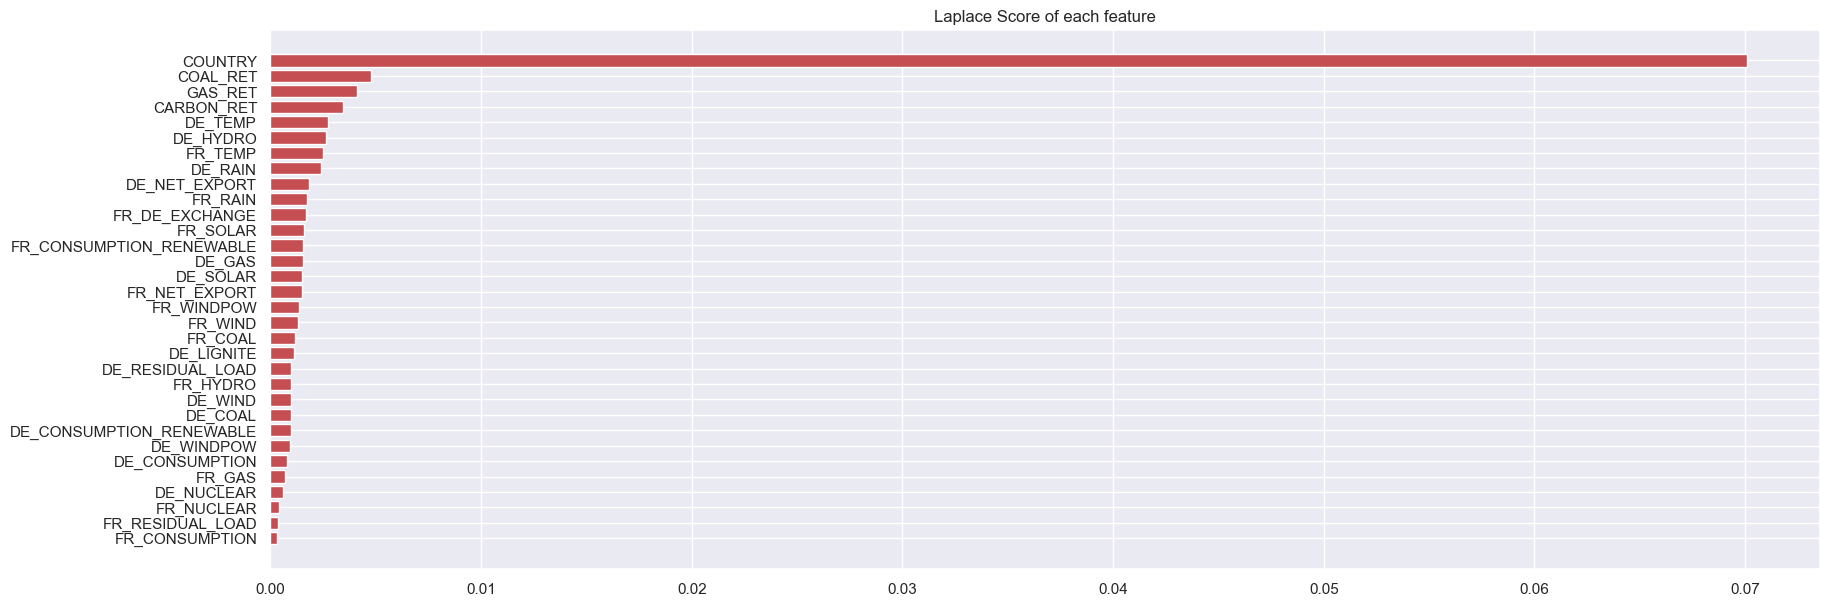

100%|██████████| 30/30 [00:06<00:00,  4.67it/s]


The best_score =  0.20736304266706412
The best_score_FR =  0.09898840672108779
The best_score_DE =  0.3182644943507397
The best_features =  ['FR_CONSUMPTION', 'FR_RESIDUAL_LOAD', 'FR_NUCLEAR', 'DE_NUCLEAR', 'FR_GAS', 'DE_CONSUMPTION', 'DE_WINDPOW', 'DE_CONSUMPTION_RENEWABLE', 'DE_COAL', 'DE_WIND', 'FR_HYDRO', 'DE_RESIDUAL_LOAD', 'DE_LIGNITE', 'FR_COAL', 'FR_WIND', 'FR_WINDPOW', 'FR_NET_EXPORT', 'DE_SOLAR', 'DE_GAS', 'FR_CONSUMPTION_RENEWABLE', 'FR_SOLAR', 'FR_DE_EXCHANGE', 'FR_RAIN', 'DE_NET_EXPORT']


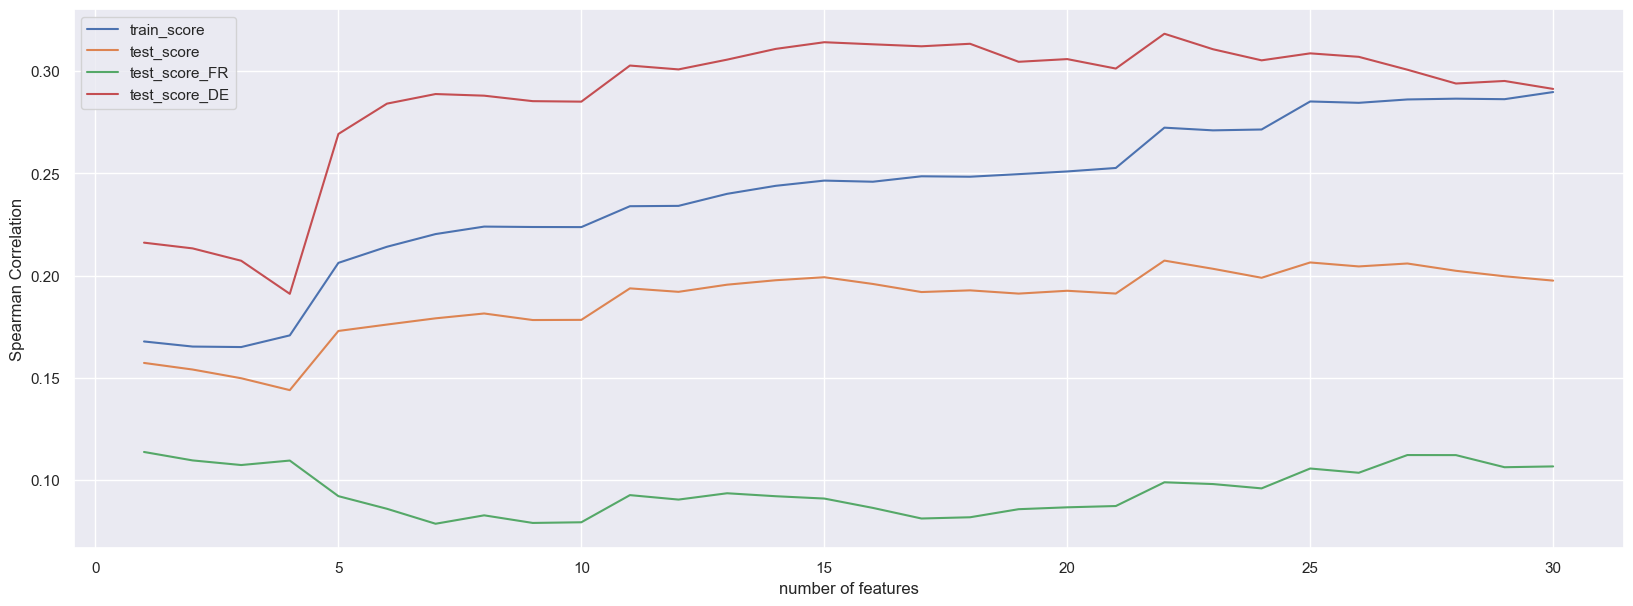

In [13]:
best_score, best_score_FR, best_score_DE, best_features = features_selection.laplace_features_selection(X_train, y_train, X_test, number_of_states = 20)

benchmark['Laplace'] = {'test_score':best_score, 'test_score_FR':best_score_FR, 'test_score_DE':best_score_DE, 'features':best_features}

print("The best_score = ", best_score)
print("The best_score_FR = ", best_score_FR)
print("The best_score_DE = ", best_score_DE)
print("The best_features = ", best_features)

## Features Selection Using Information Theory:

### Minimum Redundancy Maximum Relevance (MRMR)

The score of each new feature :
$$J_{MRMR}(X_k) = I(X_k,Y) - \frac{1}{|S|}\sum_{X_j \in s}I(X_k,x_j)$$

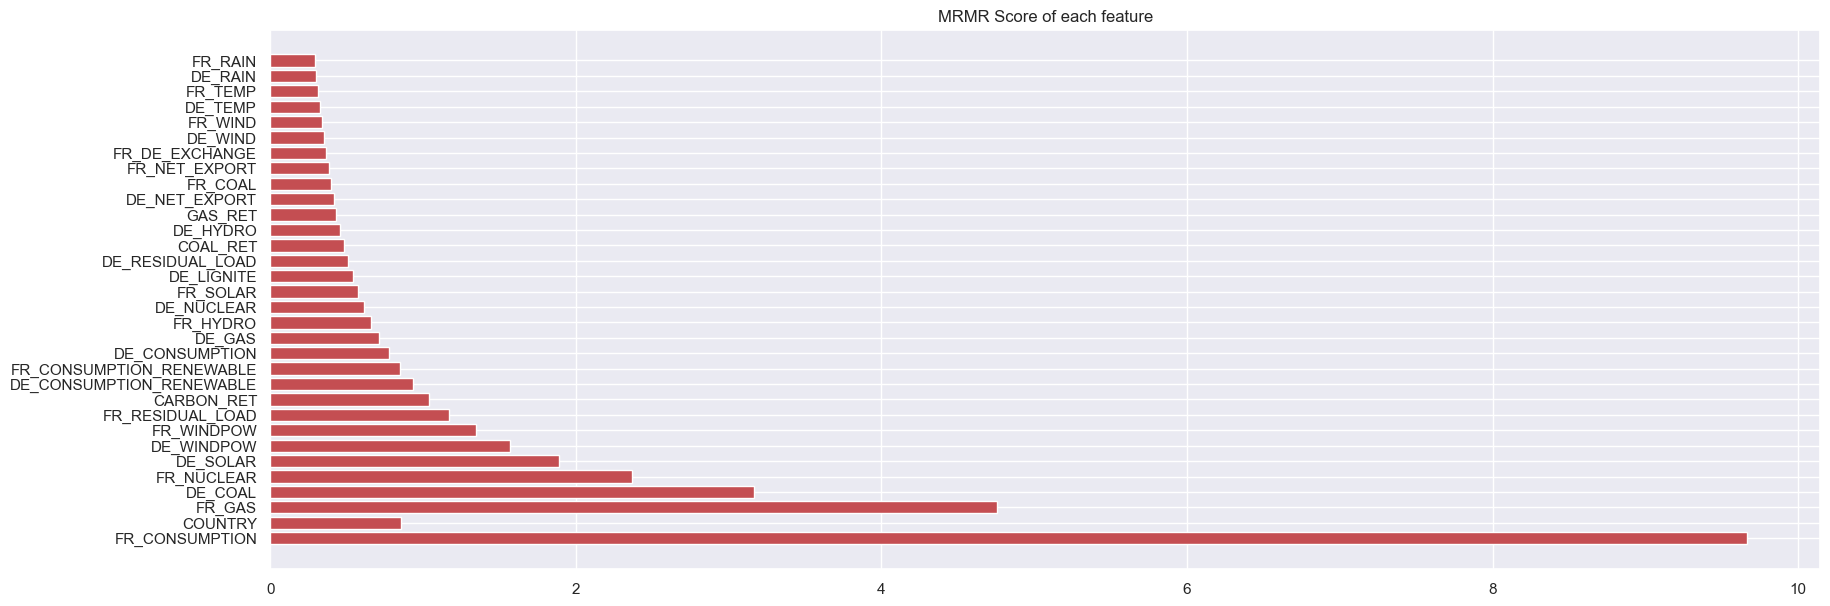

100%|██████████| 30/30 [00:05<00:00,  5.58it/s]


The best_score =  0.21265610857320433
The best_score_FR =  0.10710935547337248
The best_score_DE =  0.31546510707065745
The best_features =  ['FR_CONSUMPTION', 'COUNTRY', 'FR_GAS', 'DE_COAL', 'FR_NUCLEAR', 'DE_SOLAR', 'DE_WINDPOW', 'FR_WINDPOW', 'FR_RESIDUAL_LOAD', 'CARBON_RET', 'DE_CONSUMPTION_RENEWABLE', 'FR_CONSUMPTION_RENEWABLE', 'DE_CONSUMPTION', 'DE_GAS', 'FR_HYDRO', 'DE_NUCLEAR', 'FR_SOLAR', 'DE_LIGNITE', 'DE_RESIDUAL_LOAD', 'COAL_RET', 'DE_HYDRO', 'GAS_RET', 'DE_NET_EXPORT']


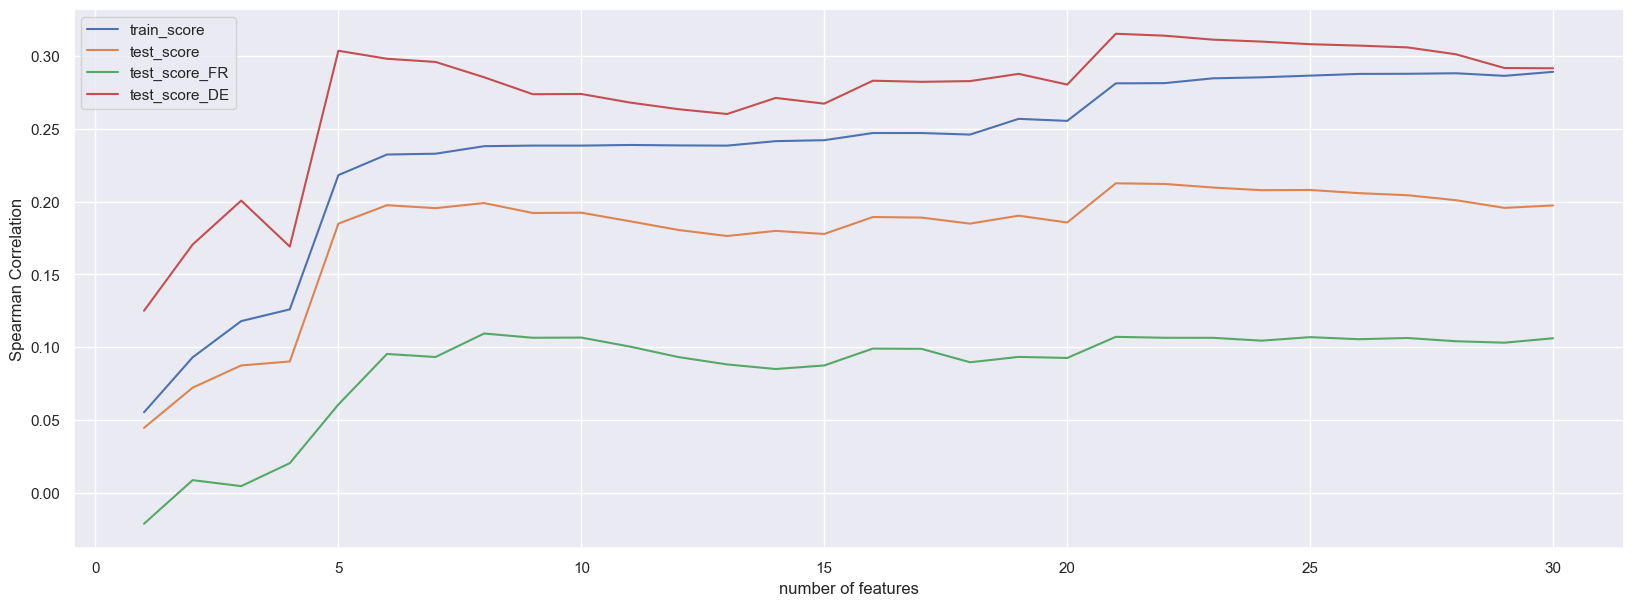

In [14]:
best_score, best_score_FR, best_score_DE, best_features = features_selection.MRMR_features_selection(X_train, y_train, X_test, number_of_states = 20)

benchmark['MRMR'] = {'test_score':best_score, 'test_score_FR':best_score_FR, 'test_score_DE':best_score_DE, 'features':best_features}

print("The best_score = ", best_score)
print("The best_score_FR = ", best_score_FR)
print("The best_score_DE = ", best_score_DE)
print("The best_features = ", best_features)

## Create new features

Let us in this part, create new features and test the methods above

In [15]:
all_data_clean = utils.add_new_features(all_data_clean)

# Get the original split
X_train, y_train, X_test, id_test = utils.split(all_data_clean)
X_test.index = id_test

# center the country column
X_train['COUNTRY'] = 2*X_train['COUNTRY'] - 1 
X_test['COUNTRY'] = 2*X_test['COUNTRY'] - 1 



poly = PolynomialFeatures(2,include_bias = False)
X_train_augmented  = poly.fit_transform(X_train)
X_test_augmented = poly.transform(X_test)
X_train_augmented = pd.DataFrame(columns=poly.get_feature_names(X_train.columns),data = np.array(X_train_augmented))
X_test_augmented = pd.DataFrame(columns=poly.get_feature_names(X_train.columns),data = np.array(X_test_augmented))



# Scale the data to be between zero and one 
X = pd.concat([X_train_augmented, X_test_augmented])
scaler = StandardScaler()
scaler.fit(X)
cols = X.columns

X_train_scaled = X_train_augmented.copy()
X_test_scaled = X_test_augmented.copy()

X_train_scaled[cols] = scaler.transform(X_train_augmented[cols])
X_test_scaled[cols] = scaler.transform(X_test_augmented[cols])

X_train_scaled['COUNTRY_split'] = X_train['COUNTRY']

X_train = X_train_scaled
X_test = X_test_scaled


### Lasso Features Selection

In [16]:
'''
regularization, best_score, best_score_FR, best_score_DE, best_features = features_selection.lasso_feature_selection(X_train, y_train, number_of_states = 5)

benchmark['lasso'] = {'test_score':best_score, 'test_score_FR':best_score_FR, 'test_score_DE':best_score_DE, 'features':best_features}

print("The best regularization = ", regularization)
print("The best_score = ", best_score)
print("The best_score_FR = ", best_score_FR)
print("The best_score_DE = ", best_score_DE)
print("The best_features = ", best_features)
'''

'\nregularization, best_score, best_score_FR, best_score_DE, best_features = features_selection.lasso_feature_selection(X_train, y_train, number_of_states = 5)\n\nbenchmark[\'lasso\'] = {\'test_score\':best_score, \'test_score_FR\':best_score_FR, \'test_score_DE\':best_score_DE, \'features\':best_features}\n\nprint("The best regularization = ", regularization)\nprint("The best_score = ", best_score)\nprint("The best_score_FR = ", best_score_FR)\nprint("The best_score_DE = ", best_score_DE)\nprint("The best_features = ", best_features)\n'

### Feature Selection Using Laplace Score

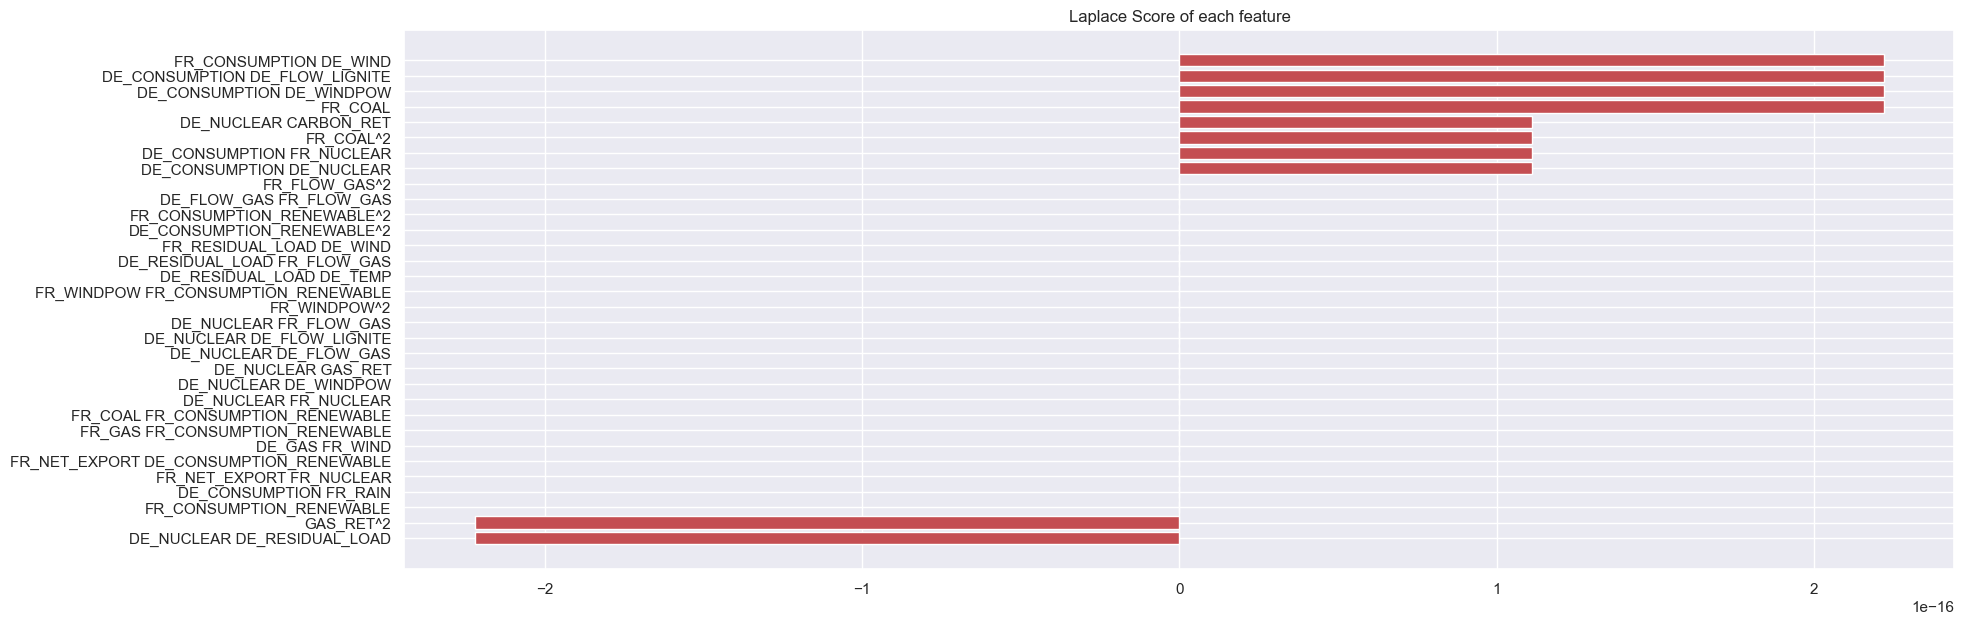

100%|██████████| 30/30 [00:05<00:00,  5.44it/s]


The best_score =  0.15659267301390573
The best_score_FR =  0.08398482430931861
The best_score_DE =  0.24308335955843816
The best_features =  ['DE_NUCLEAR DE_RESIDUAL_LOAD', 'GAS_RET^2', 'FR_CONSUMPTION_RENEWABLE']


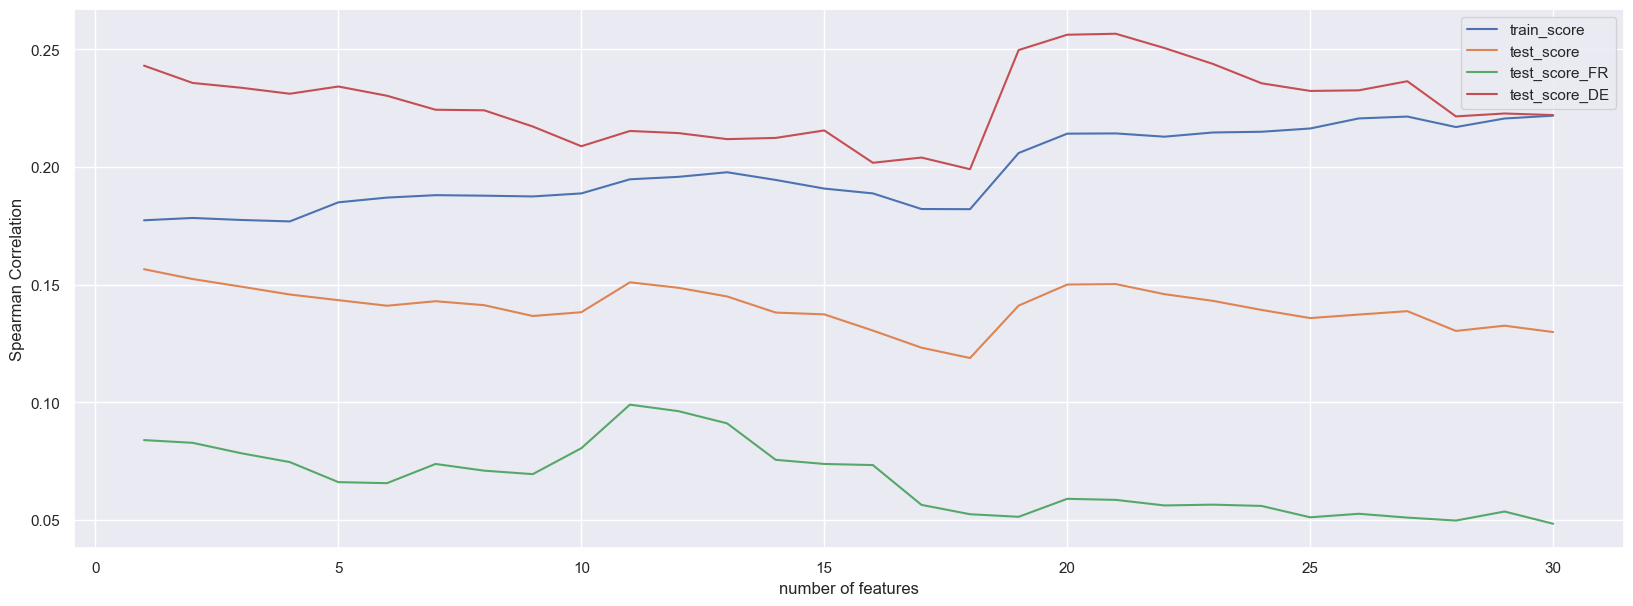

In [17]:
best_score, best_score_FR, best_score_DE, best_features = features_selection.laplace_features_selection(X_train, y_train, X_test, number_of_states = 20)

benchmark['Laplace'] = {'test_score':best_score, 'test_score_FR':best_score_FR, 'test_score_DE':best_score_DE, 'features':best_features}

print("The best_score = ", best_score)
print("The best_score_FR = ", best_score_FR)
print("The best_score_DE = ", best_score_DE)
print("The best_features = ", best_features)


## Features Selection Using Information Theory:

### Minimum Redundancy Maximum Relevance (MRMR)

The score of each new feature :
$$J_{MRMR}(X_k) = I(X_k,Y) - \frac{1}{|S|}\sum_{X_j \in s}I(X_k,x_j)$$

In [18]:
best_score, best_score_FR, best_score_DE, best_features = features_selection.MRMR_features_selection(X_train, y_train, X_test, number_of_states = 5)

benchmark['MRMR'] = {'test_score':best_score, 'test_score_FR':best_score_FR, 'test_score_DE':best_score_DE, 'features':best_features}

print("The best_score = ", best_score)
print("The best_score_FR = ", best_score_FR)
print("The best_score_DE = ", best_score_DE)
print("The best_features = ", best_features)

KeyboardInterrupt: 